#### Skripsi Prediksi Komplikasi Hemodialisis Menggunakan XGBOOST dengan Artificial Bee Colony ####

Nama  : Rangga Laksana Aryananda
NPM   : 21083010036
Prodi : Sains Data

### Import Library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from abc import ABC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


### Import Dataset

In [2]:
# Import Dataset HD
file_path = r"C:\Users\lenovo\Desktop\AMBIS SKRIPSI\DATA PASIEN HD 2.xlsx"

# Membaca file Excel
data = pd.read_excel(file_path)

data

,Inisial_Pasien,Jenis_Kelamin,usia,Sistolik,Diastolik,Hemoglobin,SI-TIBC_(%),Ureum,Kreatinin,EPO_3000,EPO_2000,TRON_SUCROSE,lama_hemodialisis(bulan),Riwayat_penyakit_keluarga,Riwayat_penyakit,Komplikasi,Jenis_Komplikasi
0,Ny SA,perempuan,51,170,90,7.8,13.0,160.3,10.71,ya,tidak,1.91,36.0,hipertensi,hipertensi,ya,hipertensi
1,Tn Dj,laki-laki,81,120,80,7.3,35.0,132.3,8.64,ya,tidak,1.74,18.0,hipertensi,hipertensi,ya,hipertensi
2,Tn SH,laki-laki,56,170,100,8.7,30.0,149.7,14.93,tidak,tidak,1.26,18.0,tidak ada,diabetes,ya,hipertensi
3,Tn SZ,laki-laki,42,120,80,11.1,93.0,160.5,11.27,tidak,tidak,1.36,36.0,tidak ada,tidak ada,ya,gastrointestinal
4,Tn Mu,laki-laki,66,120,100,10.2,29.0,122.2,11.42,tidak,ya,1.45,36.0,lambung,jantung koroner,ya,gastrointestinal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,Tn Ag,laki-laki,53,120,90,7.0,90.0,34.6,2.55,ya,tidak,1.50,24.0,tidak ada,diabetes,ya,gastrointestinal
382,Ny Mis,perempuan,60,120,90,7.2,77.0,53.5,9.67,ya,tidak,NaN,6.0,hipertensi,diabetes,ya,gastrointestinal
383,Tn Fer,laki-laki,37,100,80,10.3,15.0,45.7,4.54,tidak,tidak,1.10,7.0,diabetes,lambung,ya,hipotensi
384,Ny Wij,perempuan,64,120,80,8.2,83.0,97.5,9.77,ya,tidak,NaN,70.0,hipertensi,hipertensi,ya,gastrointestinal


### Data Preprocessing

In [3]:
# hapus kolom data
# data.drop('Nama', axis=1, inplace=True)

In [4]:
# handle nilai kosong pada data numerik dengan rata-rata
data['Sistolik'].fillna(data['Sistolik'].mean(), inplace=True)
data['usia'].fillna(data['usia'].mean(), inplace=True)
data['Hemoglobin'].fillna(data['Hemoglobin'].mean(), inplace=True)
data['Diastolik'].fillna(data['Diastolik'].mean(), inplace=True)
data['SI-TIBC_(%)'].fillna(data['SI-TIBC_(%)'].mean(), inplace=True)
data['TRON_SUCROSE'].fillna(data['TRON_SUCROSE'].mean(), inplace=True)
data['Ureum'].fillna(data['Ureum'].mean(), inplace=True)
data['Kreatinin'].fillna(data['Kreatinin'].mean(), inplace=True)

# handle nilai kosong pada data kategorikal dengan modus  
data['EPO_3000'].fillna(data['EPO_3000'].mode().iloc[0], inplace=True)
data['EPO_2000'].fillna(data['EPO_2000'].mode().iloc[0], inplace=True)


In [5]:
data.isnull().sum()

Inisial_Pasien               0
Jenis_Kelamin                0
usia                         0
Sistolik                     0
Diastolik                    0
Hemoglobin                   0
SI-TIBC_(%)                  0
Ureum                        0
Kreatinin                    0
EPO_3000                     0
EPO_2000                     0
TRON_SUCROSE                 0
lama_hemodialisis(bulan)     0
Riwayat_penyakit_keluarga    0
Riwayat_penyakit             0
Komplikasi                   0
Jenis_Komplikasi             0
dtype: int64

In [6]:
# Mapping label untuk Jenis_Komplikasi
komplikasi_mapping = {
    'tidak ada': 0,
    'hipertensi': 1,
    'hipotensi': 2,
    'gastrointestinal': 3 
}

# Terapkan mapping khusus
data['Jenis_Komplikasi'] = data['Jenis_Komplikasi'].map(komplikasi_mapping)

# Daftar kolom kategorikal yang lain
categorical_columns = ['Jenis_Kelamin', 'EPO_3000', 'EPO_2000', 'Riwayat_penyakit', 'Riwayat_penyakit_keluarga', 'Komplikasi']

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Loop untuk encoding setiap kolom kecuali 'Jenis_Komplikasi'
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

data


,Inisial_Pasien,Jenis_Kelamin,usia,Sistolik,Diastolik,Hemoglobin,SI-TIBC_(%),Ureum,Kreatinin,EPO_3000,EPO_2000,TRON_SUCROSE,lama_hemodialisis(bulan),Riwayat_penyakit_keluarga,Riwayat_penyakit,Komplikasi,Jenis_Komplikasi
0,Ny SA,1,51,170,90,7.8,13.0,160.3,10.71,1,0,1.910000,36.0,5,6,1,1
1,Tn Dj,0,81,120,80,7.3,35.0,132.3,8.64,1,0,1.740000,18.0,5,6,1,1
2,Tn SH,0,56,170,100,8.7,30.0,149.7,14.93,0,0,1.260000,18.0,9,4,1,1
3,Tn SZ,0,42,120,80,11.1,93.0,160.5,11.27,0,0,1.360000,36.0,9,13,1,3
4,Tn Mu,0,66,120,100,10.2,29.0,122.2,11.42,0,1,1.450000,36.0,8,9,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,Tn Ag,0,53,120,90,7.0,90.0,34.6,2.55,1,0,1.500000,24.0,9,4,1,3
382,Ny Mis,1,60,120,90,7.2,77.0,53.5,9.67,1,0,1.427706,6.0,5,4,1,3
383,Tn Fer,0,37,100,80,10.3,15.0,45.7,4.54,0,0,1.100000,7.0,3,11,1,2
384,Ny Wij,1,64,120,80,8.2,83.0,97.5,9.77,1,0,1.427706,70.0,5,6,1,3


In [7]:
data3=data.copy()
# hapus 2 kolom data
data3.drop('Inisial_Pasien', axis=1, inplace=True)
data3.drop('Komplikasi', axis=1, inplace=True)

In [8]:
data3

,Jenis_Kelamin,usia,Sistolik,Diastolik,Hemoglobin,SI-TIBC_(%),Ureum,Kreatinin,EPO_3000,EPO_2000,TRON_SUCROSE,lama_hemodialisis(bulan),Riwayat_penyakit_keluarga,Riwayat_penyakit,Jenis_Komplikasi
0,1,51,170,90,7.8,13.0,160.3,10.71,1,0,1.910000,36.0,5,6,1
1,0,81,120,80,7.3,35.0,132.3,8.64,1,0,1.740000,18.0,5,6,1
2,0,56,170,100,8.7,30.0,149.7,14.93,0,0,1.260000,18.0,9,4,1
3,0,42,120,80,11.1,93.0,160.5,11.27,0,0,1.360000,36.0,9,13,3
4,0,66,120,100,10.2,29.0,122.2,11.42,0,1,1.450000,36.0,8,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,0,53,120,90,7.0,90.0,34.6,2.55,1,0,1.500000,24.0,9,4,3
382,1,60,120,90,7.2,77.0,53.5,9.67,1,0,1.427706,6.0,5,4,3
383,0,37,100,80,10.3,15.0,45.7,4.54,0,0,1.100000,7.0,3,11,2
384,1,64,120,80,8.2,83.0,97.5,9.77,1,0,1.427706,70.0,5,6,3


In [9]:
best_accuracy = 0  # Reset nilai sebelum memulai optimasi baru

# Modeling Data

### SET PARAMETER ABC TERBAIK 

#### Skema Uji : 

N bees = 20
max iter = 20
limit = 10


### Pembagian Dataset

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

# Pisahkan fitur dan target
X = data3.iloc[:, :-1]  # Fitur
Y = data3['Jenis_Komplikasi']  # Target

# Gunakan K-Fold Cross Validation dengan 5 fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Terapkan SMOTE pada data training untuk menyeimbangkan kelas
    smote = SMOTE(random_state=42)
    X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

### Evaluasi Hyperparameter

In [11]:
def evaluate_hyperparameters(params):
    """
    Menghitung error (1 - akurasi rata-rata) menggunakan 3-fold CV
    untuk kombinasi hiperparameter yang diberikan.
    
    Parameter yang dioptimasi:
    - n_estimators: jumlah pohon keputusan
    - learning_rate: ukuran langkah pembelajaran
    - reg_lambda: parameter regularisasi
    - max_depth: kedalaman maksimum pohon
    - min_child_weight: minimum bobot anak
    - gamma: parameter pruning
    - subsample: fraksi sampel data
    - colsample_bytree: fraksi fitur
    """
    # Ekstraksi dan konversi tipe data parameter
    n_estimators = int(round(params[0]))
    learning_rate = params[1]
    reg_lambda = params[2]
    max_depth = int(round(params[3]))
    min_child_weight = int(round(params[4]))
    gamma = params[5]
    subsample = params[6]
    colsample_bytree = params[7]
    
    model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    scores = cross_val_score(model, X_train, Y_train, cv=3, scoring='accuracy')
    error = 1 - scores.mean()  # Semakin kecil error, semakin baik solusi
    return error


### Build Algoritma ABC Untuk Optimasi

In [12]:
class ArtificialBeeColony:
    def __init__(self, func, dim, lb, ub, n_bees, max_iter, limit):
        """
        func      : fungsi evaluasi (mengembalikan error)
        dim       : jumlah dimensi (parameter yang dioptimasi)
        lb, ub    : batas bawah dan atas tiap dimensi (array)
        n_bees    : jumlah solusi (food sources)
        max_iter  : jumlah iterasi maksimum (MCN)
        limit     : batas iterasi tanpa perbaikan sebelum scout bee menginisialisasi ulang solusi
        """
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.n_bees = n_bees
        self.max_iter = max_iter
        self.limit = limit
        
        # Inisialisasi populasi awal
        self.population = np.random.uniform(0, 1, (n_bees, dim)) * (self.ub - self.lb) + self.lb
        self.fitness = np.array([func(ind) for ind in self.population])
        self.trial = np.zeros(n_bees)  # Hitungan trial tiap solusi
        self.fitness_history = []  # Menyimpan riwayat fitness setiap iterasi

    def optimize(self):
        best_solution = None
        best_fitness = np.inf
        
        for iter in range(self.max_iter):
            # Fase Employed Bee
            for i in range(self.n_bees):
                candidate = np.copy(self.population[i])
                j = np.random.randint(0, self.dim)
                k = np.random.choice([idx for idx in range(self.n_bees) if idx != i])
                phi = np.random.uniform(-1, 1)
                candidate[j] = self.population[i][j] + phi * (self.population[i][j] - self.population[k][j])
                candidate[j] = np.clip(candidate[j], self.lb[j], self.ub[j])
                
                candidate_fitness = self.func(candidate)
                if candidate_fitness < self.fitness[i]:
                    self.population[i] = candidate
                    self.fitness[i] = candidate_fitness
                    self.trial[i] = 0
                else:
                    self.trial[i] += 1

            # Fase Onlooker Bee
            sum_accuracies = np.sum(1 - self.fitness)
            if sum_accuracies == 0:
                probabilities = np.ones(self.n_bees) / self.n_bees
            else:
                probabilities = 1 - (self.fitness / sum_accuracies)
                probabilities = probabilities / np.sum(probabilities)
            
            for i in range(self.n_bees):
                selected_index = np.random.choice(np.arange(self.n_bees), p=probabilities)
                candidate = np.copy(self.population[selected_index])
                j = np.random.randint(0, self.dim)
                k = np.random.choice([idx for idx in range(self.n_bees) if idx != selected_index])
                phi = np.random.uniform(-1, 1)
                candidate[j] = self.population[selected_index][j] + phi * (self.population[selected_index][j] - self.population[k][j])
                candidate[j] = np.clip(candidate[j], self.lb[j], self.ub[j])
                candidate_fitness = self.func(candidate)
                if candidate_fitness < self.fitness[selected_index]:
                    self.population[selected_index] = candidate
                    self.fitness[selected_index] = candidate_fitness
                    self.trial[selected_index] = 0
                else:
                    self.trial[selected_index] += 1
            
            # Fase Scout Bee
            for i in range(self.n_bees):
                if self.trial[i] > self.limit:
                    self.population[i] = np.random.uniform(0, 1, self.dim) * (self.ub - self.lb) + self.lb
                    self.fitness[i] = self.func(self.population[i])
                    self.trial[i] = 0

            best_iter_index = np.argmin(self.fitness)
            if self.fitness[best_iter_index] < best_fitness:
                best_fitness = self.fitness[best_iter_index]
                best_solution = self.population[best_iter_index].copy()

            # Menyimpan riwayat fitness setiap iterasi
            self.fitness_history.append(best_fitness)
            print(f"Iterasi {iter+1}/{self.max_iter}, Best Fitness: {best_fitness:.4f}")
        
        return best_solution, best_fitness


### Optimasi Hyperparameter dengan ABC

In [13]:
# Inisialisasi parameter XGboost yang akan dioptimasi
# n_estimators, learning_rate, reg_lambda, max_depth, min_child_weight, gamma, subsample, colsample_bytree
dim = 8
lb = [100, 0.001, 0,    3,  0, 0,   0, 0]      # batas bawah tiap parameter
ub = [1000, 1,   100, 10, 100, 1,   1, 1]      # batas atas tiap parameter

n_bees = 20      # Jumlah solusi (food sources)
max_iter = 20    # Jumlah iterasi maksimum
limit = 10        # Batas trial sebelum scout bee menginisialisasi ulang solusi

abc = ArtificialBeeColony(evaluate_hyperparameters, dim, lb, ub, n_bees, max_iter, limit)
best_params, best_error = abc.optimize()

# Ubah parameter terbaik menjadi tipe data yang sesuai
best_n_estimators  = int(round(best_params[0]))
best_learning_rate = best_params[1]
best_reg_lambda    = best_params[2]
best_max_depth     = int(round(best_params[3]))
best_min_child_weight = int(round(best_params[4]))
best_gamma         = best_params[5]
best_subsample     = best_params[6]
best_colsample_bytree = best_params[7]

print("\nHyperparameter terbaik:")
print("n_estimators     :", best_n_estimators)
print("learning_rate    :", best_learning_rate)
print("reg_lambda       :", best_reg_lambda)
print("max_depth        :", best_max_depth)
print("min_child_weight :", best_min_child_weight)
print("gamma            :", best_gamma)
print("subsample        :", best_subsample)
print("colsample_bytree :", best_colsample_bytree)
print("Error (1 - CV Accuracy):", best_error)


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:00:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 1/20, Best Fitness: 0.2427


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:01:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:01:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:01:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 2/20, Best Fitness: 0.1586


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 3/20, Best Fitness: 0.1456


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 4/20, Best Fitness: 0.1392


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:03:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 5/20, Best Fitness: 0.1327


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:04:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:04:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:04:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 6/20, Best Fitness: 0.1327


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 7/20, Best Fitness: 0.1327


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:06:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 8/20, Best Fitness: 0.1262


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:07:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:07:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 9/20, Best Fitness: 0.1262


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 10/20, Best Fitness: 0.1262


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 11/20, Best Fitness: 0.1262


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:10:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:10:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:10:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 12/20, Best Fitness: 0.1230


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:11:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:11:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:11:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 13/20, Best Fitness: 0.1230


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:12:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:12:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 14/20, Best Fitness: 0.1230


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:13:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:13:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:13:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 15/20, Best Fitness: 0.1197


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:14:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:14:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:14:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 16/20, Best Fitness: 0.1197


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:15:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:15:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:15:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 17/20, Best Fitness: 0.1197


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:16:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:16:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:16:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 18/20, Best Fitness: 0.1197


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 19/20, Best Fitness: 0.1197


c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lenovo\anaconda3\Lib\site-packa

Iterasi 20/20, Best Fitness: 0.1197

Hyperparameter terbaik:
n_estimators     : 424
learning_rate    : 0.9292410392995984
reg_lambda       : 16.479841333400593
max_depth        : 9
min_child_weight : 0
gamma            : 0.48330343990947144
subsample        : 0.9781763783954378
colsample_bytree : 0.46376524559650895
Error (1 - CV Accuracy): 0.1197411003236245


### Implementasi XGBoost dengan Parameter Optimal

c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Akurasi pada data test: 0.8701298701298701

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87        28
           1       0.93      0.87      0.90        15
           2       0.92      0.69      0.79        16
           3       0.89      0.94      0.92        18

    accuracy                           0.87        77
   macro avg       0.89      0.86      0.87        77
weighted avg       0.88      0.87      0.87        77



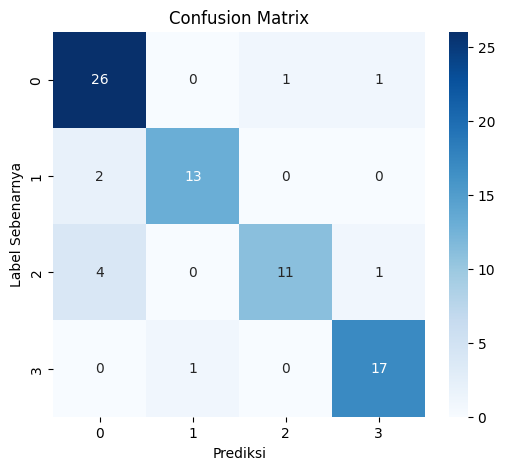

In [14]:
# LATIH MODEL DENGAN HIPERPARAMETER TERBAIK
model = XGBClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    reg_lambda=best_reg_lambda,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("\nAkurasi pada data test:", accuracy)
print("\nLaporan Klasifikasi:\n", classification_report(Y_test, Y_pred))

# Optional: Tampilkan Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Label Sebenarnya")
plt.show()

### Fitness Iteration History

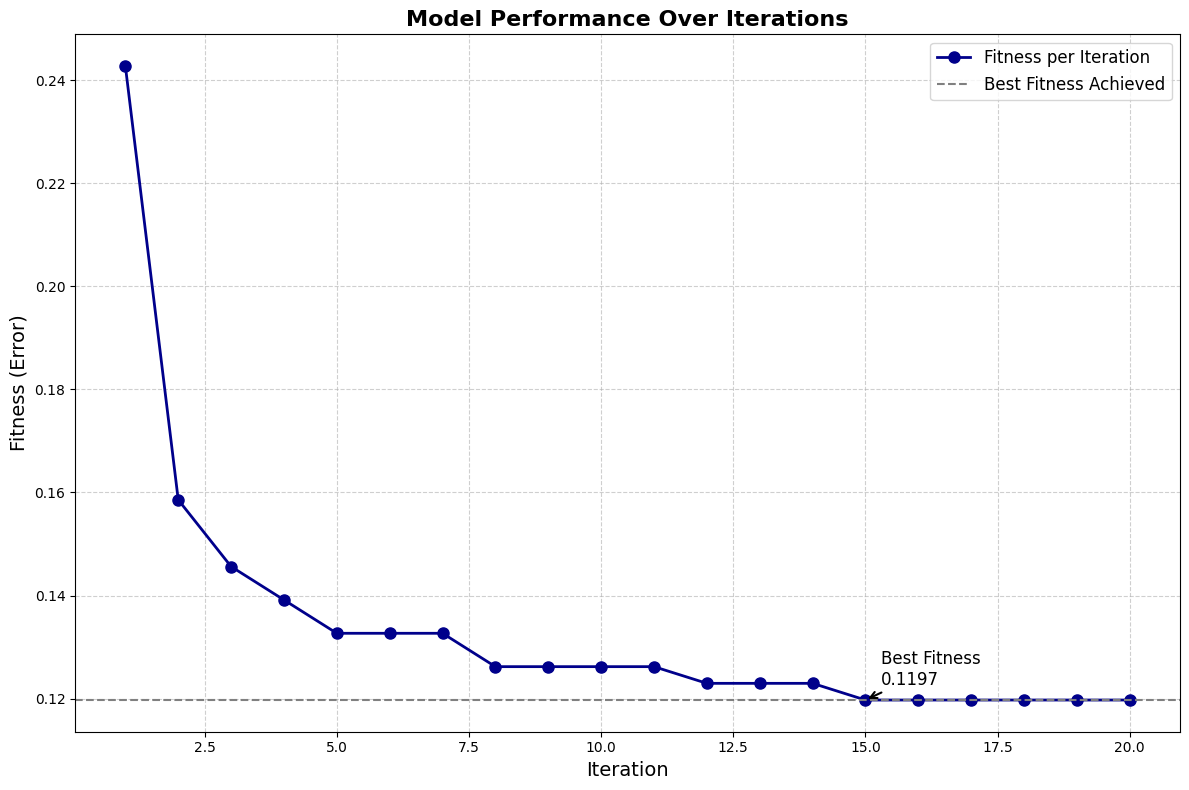

In [15]:
# Fungsi untuk memvisualisasikan performa model selama iterasi
def plot_fitness_performance(fitness_history):
    # Membuat figure dengan ukuran yang lebih besar
    plt.figure(figsize=(12, 8))
    
    # Plotkan fitness history dengan penanda titik yang lebih jelas
    plt.plot(range(1, len(fitness_history) + 1), fitness_history, marker='o', color='darkblue', linestyle='-', linewidth=2, markersize=8, label="Fitness per Iteration")
    
    # Menambahkan garis horizontal untuk menunjukkan fitness optimal (misalnya target fitness)
    plt.axhline(y=min(fitness_history), color='gray', linestyle='--', label='Best Fitness Achieved')
    
    # Memberikan judul dan label yang lebih informatif dengan ukuran font yang lebih besar
    plt.title('Model Performance Over Iterations', fontsize=16, fontweight='bold')
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Fitness (Error)', fontsize=14)
    
    # Menambahkan grid halus untuk meningkatkan keterbacaan
    plt.grid(True, linestyle='--', alpha=0.6)

    # Menambahkan anotasi untuk iterasi dengan fitness terbaik
    best_iter = np.argmin(fitness_history) + 1  # Menambah 1 karena indeks mulai dari 0
    best_fitness = min(fitness_history)
    plt.annotate(f'Best Fitness\n{best_fitness:.4f}', 
                 xy=(best_iter, best_fitness), 
                 xytext=(best_iter + 0.3, best_fitness + 0.003),  # Mengatur teks lebih dekat
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),  # Memperpendek panah
                 fontsize=12, color='black')

    # Menambahkan legenda yang jelas
    plt.legend(loc='upper right', fontsize=12)

    # Mengatur layout agar elemen tidak tumpang tindih
    plt.tight_layout()
    
    # Tampilkan grafik
    plt.show()

# Setelah optimasi, panggil fungsi ini untuk melihat hasilnya
plot_fitness_performance(abc.fitness_history)


### Evaluasi Grafik ROC - AUC 

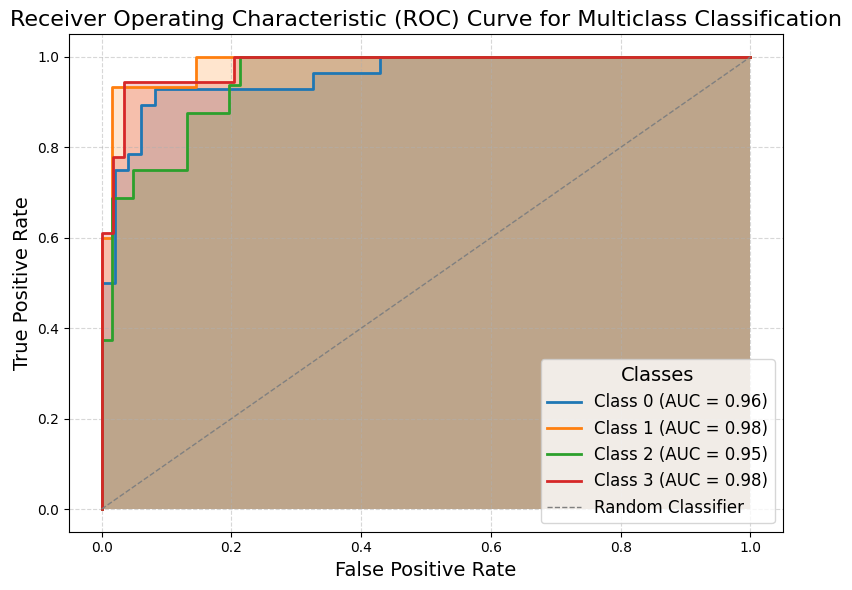

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarisasi label untuk multiclass ROC curve
Y_bin = label_binarize(Y_test, classes=[0, 1, 2, 3])
Y_score = model.predict_proba(X_test)

# Menghitung ROC curve dan AUC untuk setiap kelas
plt.figure(figsize=(8, 6))

for i in range(4):
    fpr, tpr, _ = roc_curve(Y_bin[:, i], Y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve untuk masing-masing kelas
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})', linewidth=2)

    # Mengisi area di bawah ROC curve untuk menonjolkan AUC
    plt.fill_between(fpr, tpr, alpha=0.2)

# Menambahkan garis diagonal sebagai perbandingan
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier', linewidth=1)

# Menambahkan label dan judul dengan font lebih besar untuk jurnal
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification', fontsize=16)

# Menambahkan grid untuk memudahkan pembacaan
plt.grid(True, linestyle='--', alpha=0.5)

# Menambahkan legenda yang lebih jelas dan terorganisir
plt.legend(loc='lower right', fontsize=12, title="Classes", title_fontsize=14)

# Menampilkan grafik
plt.tight_layout()
plt.show()


### Evaluasi Learning Curve

c:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique value

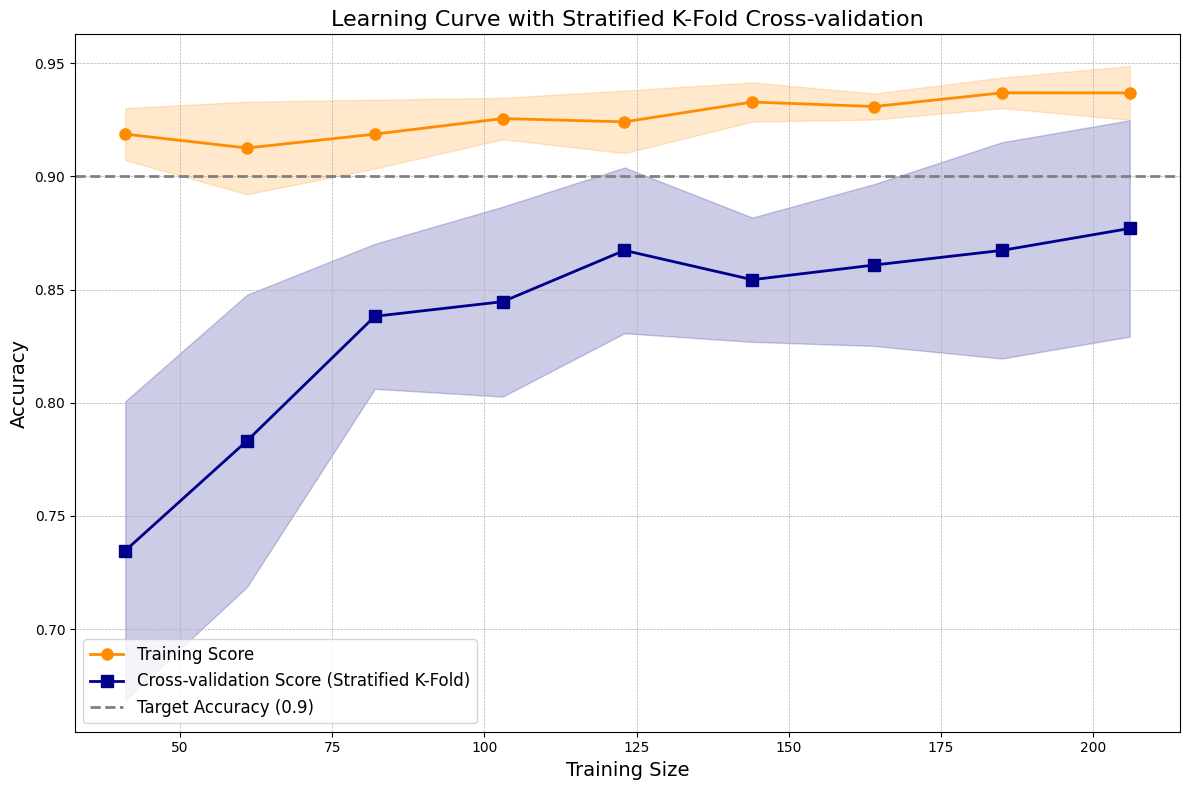

In [17]:
from sklearn.model_selection import StratifiedKFold, learning_curve

# Menghitung learning curve dengan Stratified K-Folds
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Gunakan StratifiedKFold
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, Y_train, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Menghitung nilai rata-rata dan standar deviasi untuk plot
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Menemukan indeks dengan akurasi tertinggi untuk Training dan Cross-validation
max_train_index = np.argmax(train_mean)
max_test_index = np.argmax(test_mean)

# Visualisasi Learning Curve yang lebih menarik
plt.figure(figsize=(12, 8))

# Plot untuk Training dan Cross-validation scores
plt.plot(train_sizes, train_mean, color='darkorange', label='Training Score', marker='o', markersize=8, linestyle='-', linewidth=2)
plt.plot(train_sizes, test_mean, color='darkblue', label='Cross-validation Score (Stratified K-Fold)', marker='s', markersize=8, linestyle='-', linewidth=2)

# Menambahkan error bar dengan transparansi lebih halus
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='darkorange', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='darkblue', alpha=0.2)

# Menambahkan garis dasar untuk target akurasi atau benchmark
plt.axhline(y=0.9, color='gray', linestyle='--', label='Target Accuracy (0.9)', linewidth=2)

# Menambahkan label dan judul yang lebih jelas
plt.xlabel('Training Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Learning Curve with Stratified K-Fold Cross-validation', fontsize=16)
plt.legend(loc='best', fontsize=12)

# Menambahkan grid untuk memudahkan interpretasi grafik
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Menambahkan anotasi untuk titik dengan akurasi tertinggi
plt.annotate(f'Training Score: {train_mean[max_train_index]:.2f}',
             xy=(train_sizes[max_train_index], train_mean[max_train_index]),
             xytext=(train_sizes[max_train_index] + 10, train_mean[max_train_index] - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12, color='black')

plt.annotate(f'Cross-validation Score: {test_mean[max_test_index]:.2f}',
             xy=(train_sizes[max_test_index], test_mean[max_test_index]),
             xytext=(train_sizes[max_test_index] + 10, test_mean[max_test_index] - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12, color='black')

# Tampilkan grafik
plt.tight_layout()
plt.show()

### Feature Importance

C:\Users\lenovo\AppData\Local\Temp\ipykernel_37576\2546936060.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


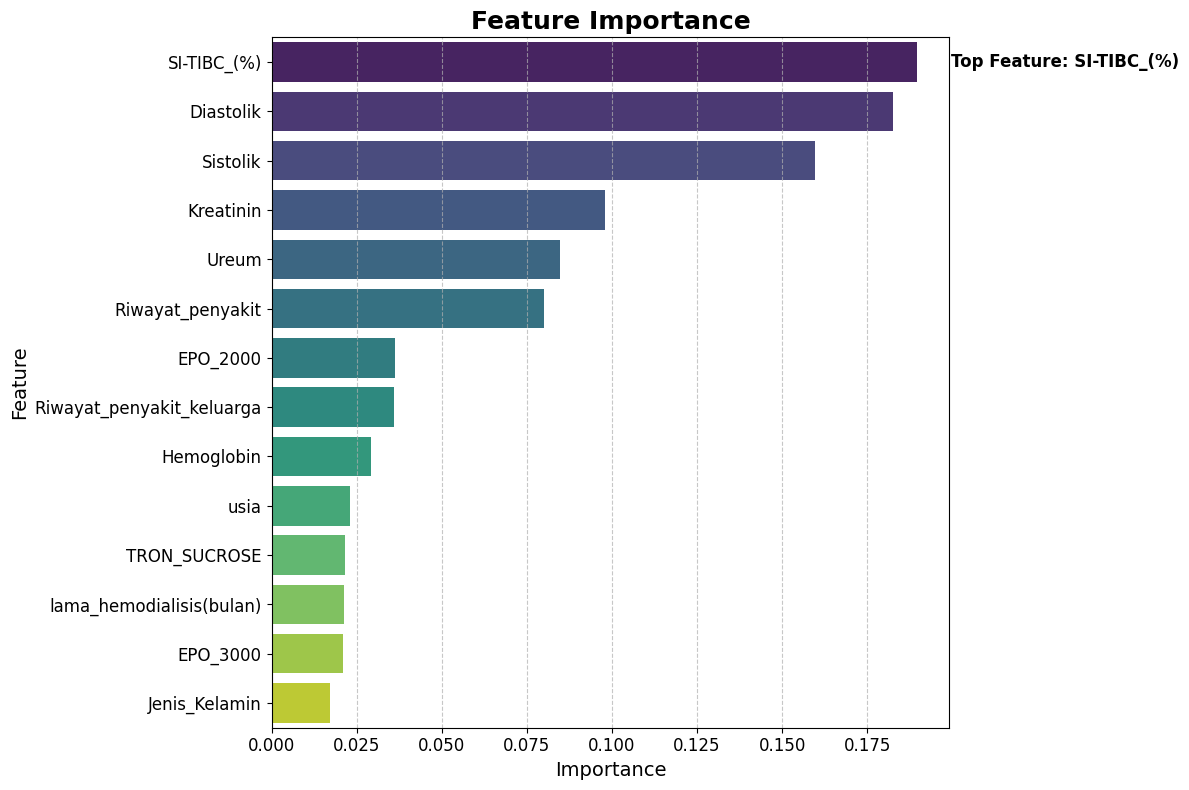

In [18]:
# Mendapatkan feature importance dari model
importances = model.feature_importances_
feature_names = X_train.columns  

# Membuat DataFrame untuk memudahkan plotting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Mengurutkan fitur berdasarkan importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Membuat bar plot dengan tampilan lebih profesional
plt.figure(figsize=(12, 8))

# Menggunakan palet warna yang lebih kontras dan menarik
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')

# Menambahkan garis grid yang lebih halus untuk estetika
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Menambahkan judul dan label yang lebih informatif
plt.title('Feature Importance', fontsize=18, fontweight='bold')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Menyoroti fitur dengan importance tertinggi
top_feature = importance_df.iloc[0]
plt.text(top_feature['importance'] + 0.01, 0, f"Top Feature: {top_feature['feature']}", 
         color='black', fontsize=12, fontweight='bold', ha='left', va='center')

# Menyesuaikan tampilan dan ukuran font agar lebih mudah dibaca
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tampilkan grafik dengan layout yang lebih baik
plt.tight_layout()
plt.show()


In [19]:
# simpan model ke dalam file
import joblib
joblib.dump(model, 'model_parameter5b.pkl')

# simpan model dalam format sav 
import pickle
pickle.dump(model, open('model_parameter5b.sav', 'wb'))

# simpan model dalam format joblib
import joblib
joblib.dump(model, 'model_parameter5b.joblib')

['model_parameter5b.joblib']